#### Problem Statement 

Building a recommendatin system for news articles, based on users interest list and the current content they are reading.

We are using doc2vec for LSI topi modelling in the recommendation system


## Table of Contents

* [1 Data Loading](#chapter1)


* [2 EDA & Viz](#chapter2)


* [3 Doc2Vec](#chapter3)


* [4 K Means](#chapter4)


* [5 LSI Topi Modelling](#chapter5)


* [6 Recommender Function](#chapter6)


* [7 References](#chapter7)

<a class="anchor" id="chapter1"></a>

### 1 Data Loading

In [9]:
# loading data

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm import tqdm

data = pd.read_csv(r'C:\Users\amits\OneDrive - University of South Florida\Fall 2022 Classes\Text Analytics\Assignment & Project\BBC Project\BBC-articles.csv')

In [10]:
# sample data

print(data.shape)
data.head(2)

(2225, 2)


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...


In [11]:
# removing limitation on # max row, # max columns, max col width

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 200)
data['text'].head(1)

0    tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically differen...
Name: text, dtype: object

In [12]:
# actual labels in the data

set(data['category'])

{'business', 'entertainment', 'politics', 'sport', 'tech'}

<a class="anchor" id="chapter2"></a>

### 2 EDA & Viz

In [15]:
# for wordclouds, cleaning the data

from textblob import TextBlob
import spacy
sp = spacy.load("en_core_web_sm")
stopwords = spacy.lang.en.stop_words.STOP_WORDS


sport = data[data['category']=='sport']
print(sport.shape)

corpus = TextBlob(' '.join((sport['text'])))
tokens = corpus.tokenize()
print(len(tokens))

stopwords.add('s')
stopwords.add('said')

words = [i for i in tokens if i not in stopwords]

(511, 2)
182670


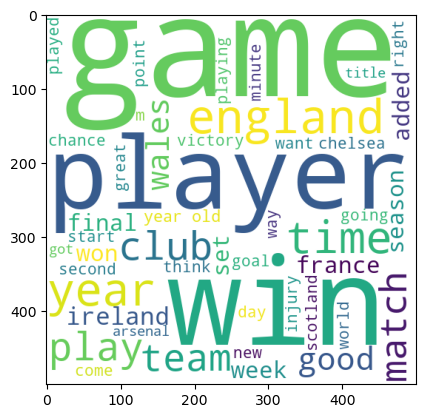

In [55]:
# wordcloud 1 for sports

text_corpus = ' '.join(words)

wordcloud = WordCloud(width=500, height=500, background_color='white', collocations='FALSE', min_font_size=16).generate(text_corpus)

plt.imshow(wordcloud)
plt.show()

<a class="anchor" id="chapter3"></a>

### 3 Doc2Vec Model

In [17]:
# loading data and running doc2vec

import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import FunctionTransformer

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess
import numpy as np

df = data

# reomve stop words and check accuracy
tokenized_list = [simple_preprocess(h, min_len=3) for h in df['text'] ]

docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(np.array(tokenized_list))]

d2v_dbow = Doc2Vec(dm=0, vector_size=500, min_count=4, workers=16, epochs=100, seed =42)
d2v_dbow.build_vocab(docs)
d2v_dbow.train(docs, total_examples=d2v_dbow.corpus_count, epochs=d2v_dbow.epochs)

C:\Users\amits\AppData\Local\Temp\ipykernel_27116\2275218647.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(np.array(tokenized_list))]


In [18]:
# infering vectors and saving 

d2v_train_x = [d2v_dbow.infer_vector(i) for i in np.array(tokenized_list)]

C:\Users\amits\AppData\Local\Temp\ipykernel_27116\38196796.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  d2v_train_x = [d2v_dbow.infer_vector(i) for i in np.array(tokenized_list)]


<a class="anchor" id="chapter4"></a>

### 4 K Means Classification

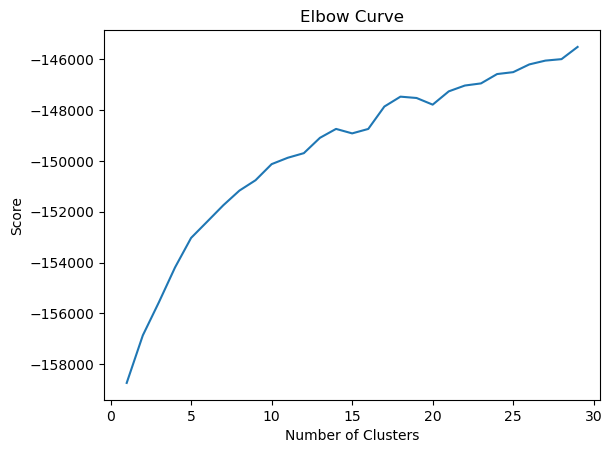

In [28]:
# running k means for 1 to 30 clusters and calculating error

from sklearn.cluster import KMeans

# Plot Elbow Curve to find optimum "K" value
N = range(1, 30)

kmeans = [KMeans(n_clusters=i) for i in N]
score = [kmeans[i].fit(d2v_train_x).score(d2v_train_x) 
         for i in range(len(kmeans))]

plt.plot(N, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [45]:
# running k means with 6 clusters

km = KMeans(n_clusters=6).fit(d2v_train_x)

labels = km.labels_
clusters = labels.tolist()

data['cluster'] = clusters
data['cluster'].value_counts()

5    506
2    504
1    442
4    405
3    221
0    147
Name: cluster, dtype: int64

<a class="anchor" id="chapter5"></a>

### 5 LSI Topi Modelling

In [48]:
# cleaning data for LSI topic modelling

from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from tqdm import tqdm
PYTHONHASHSEED=0
from textblob import TextBlob
import spacy
sp = spacy.load("en_core_web_sm")
sp_stopwords = spacy.lang.en.stop_words.STOP_WORDS

clean_text = []
for text in tqdm(data['text']):
    words = regexp_tokenize(text.lower(), r'[A-Za-z]+')
    words = [w for w in words if len(w)>2 and w not in sp_stopwords]
    words = [lemmatizer.lemmatize(w) for w in words]
    clean_text.append(words)

100%|█████████████████████████████████████████████████████████████████████████████| 2225/2225 [00:03<00:00, 640.49it/s]


In [49]:
from gensim.models import LsiModel
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
import numpy as np
import regex as re

def gensim_dtm(clean_text_c1):
    
    global dtm
    global my_dict
    global df_metrics
    global d2v
    
    for clean_text in clean_text_c1:

        my_dict = Dictionary([clean_text], prune_at=5000)
        dtm = [my_dict.doc2bow(doc) for doc in [clean_text] ]
        d2v = TfidfModel(dtm)

        lsi_model = LsiModel(corpus=dtm, id2word=my_dict, num_topics=1)
        equation_lsi = lsi_model.print_topics(-1)
        
        top_words_lsi.append(re.findall(r'"(.*?)"', equation_lsi[0][1])[0:5])

In [50]:
# savinf tags for each documents in original df

top_words_lsi = list()
top_words_lda = list()
gensim_dtm(clean_text)

data['features'] = top_words_lsi

In [118]:
# sample data with tags

data[0:2]

,category,text,cluster,features,cluster_name,og_cat_numeric,matched,match_count
0,tech,tv future in the hands of viewers with home theatre systems plasma high-definition tvs and digital video recorders moving into the living room the way people watch tv will be radically differen...,4,"[people, want, brand, network, technology]",Technology,4,{},0
1,business,worldcom boss left books alone former worldcom boss bernie ebbers who is accused of overseeing an $11bn (£5.8bn) fraud never made accounting decisions a witness has told jurors. david myers ...,2,"[worldcom, ebbers, myers, accounting, defence]",Soccer,1,{},0


In [53]:
# data.to_csv('clusters.csv')

In [54]:
# naming clusters based on top 20 tags from LSI

from collections import Counter
tmp = data[data['cluster']==2]

cluster_bow = []
for i in (tmp['features'].to_list()):
    cluster_bow.extend(i)
Counter(cluster_bow).most_common(20)

[('year', 78),
 ('company', 58),
 ('firm', 45),
 ('bank', 36),
 ('economy', 36),
 ('growth', 33),
 ('sale', 31),
 ('share', 29),
 ('profit', 26),
 ('price', 24),
 ('oil', 24),
 ('rate', 24),
 ('euro', 23),
 ('market', 21),
 ('economic', 21),
 ('government', 19),
 ('yukos', 19),
 ('new', 19),
 ('airline', 19),
 ('quarter', 17)]

In [55]:
# cluster number to name conversion

def get_cluster_names(cluster):
    
    if cluster == 4:
        return "Technology"
    elif cluster == 0:
        return "Sports"
    elif cluster == 1:
        return "Business"
    elif cluster == 2:
        return "Soccer"
    elif cluster == 3:
        return "Entertainment"
    elif cluster == 5:
        return "Politics"
    else:
        return None
    
df["cluster_name"] = df["cluster"].apply(get_cluster_names)

In [77]:
# running doc2vec with dist memory

# doc2vec_train = pd.DataFrame(d2v_train_x)

d2v_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=500, window=10,  min_count=4, workers=16)
d2v_dmm.build_vocab([x for x in tqdm(docs)])

d2v_dmm.train(docs, total_examples=d2v_dmm.corpus_count, epochs=d2v_dmm.epochs)

100%|██████████████████████████████████████████████████████████████████████████████████████| 2225/2225 [00:00<?, ?it/s]


#### Model Pairing

In [79]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
d2v_pair = ConcatenatedDoc2Vec([d2v_dbow, d2v_dmm])

<a class="anchor" id="chapter6"></a>

### 6 Recommender Function

In [92]:
# User1 is interested in tech topics; latest news around mobile phone technology and India in general
user1 = ['india','technology','phone','mobile','sony']

# User2 is interested in sports topic cricket and few sports personalities like Kohli, Dhoni
user2 = ['cricket','kholi','match','wicket']

In [113]:
# function to recommend articles
# input is current article number and interest as a list
# output is df with articles from same cluster ranked by similarity score and interest list

def find_recommendation(i,user1):
    inferred_vector = d2v_dbow.infer_vector(docs[i].words)

    sims = d2v_dbow.dv.most_similar([inferred_vector], topn=len(d2v_dbow.dv))

    df_sims = pd.DataFrame(sims, columns=['doc_id','similarty score'])
    df_sims.set_index('doc_id')

    df_final = df_sims.merge(df[['cluster_name','features']],left_on='doc_id',right_on=df.index)
    
    tmp = []
    ln = []
    for k in range(len(df_final)):
        tmp.append(set(df_final['features'][k]).intersection(user1))
        ln.append(len(set(df_final['features'][k]).intersection(user1)))
    
    df_final['matched'] = tmp
    df_final['match_count'] = ln
    
    df_final.sort_values(by = ['cluster_name', 'match_count' ,'similarty score'], inplace=True, ascending=False)
    
    return df_final

find_recommendation(2,user1)

,doc_id,similarty score,cluster_name,features,matched,match_count
672,24,0.183183,Technology,"[technology, mobile, sound, audio, phone]","{technology, phone, mobile}",3
1520,149,0.132592,Technology,"[phone, technology, network, look, mobile]","{technology, phone, mobile}",3
250,27,0.221312,Technology,"[phone, people, gig, mobile, video]","{phone, mobile}",2
290,1975,0.216683,Technology,"[phone, camera, people, use, mobile]","{phone, mobile}",2
372,2174,0.207028,Technology,"[phone, camera, people, use, mobile]","{phone, mobile}",2
395,1976,0.203776,Technology,"[mobile, music, phone, market, babinet]","{phone, mobile}",2
513,351,0.193222,Technology,"[game, mobile, console, phone, artist]","{phone, mobile}",2
517,859,0.192896,Technology,"[phone, mobile, handset, old, goodman]","{phone, mobile}",2
540,819,0.191645,Technology,"[mobile, india, market, gaming, million]","{india, mobile}",2
563,1771,0.189654,Technology,"[gadget, mobile, list, apple, phone]","{phone, mobile}",2


<a class="anchor" id="chapter7"></a>

### 7 References

https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4


https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#assessing-the-model